# Detecting BDM In Superbowl Commercials

## Notebook Settings

In [1]:

%pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 10.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 10.8 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import os

In [3]:
import logging
from datetime import datetime

# Basic function to check for missing values
def check_missing_values(df, check_for_empty_string=False):
    display(df.isnull().sum())
    # if there are none, display a ✅, otherwise display a ❌, print the rows with missing values
    if check_for_empty_string:
        display(df[df.isnull().any(axis=1)])
    if df.isnull().sum().sum() == 0:
        print("✅")
    else:
        print("❌")
        display(df[df.isnull().any(axis=1)])

logging.basicConfig(
    filename='log.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

def update_df_with_csv(df, csv_filepath, merge_key):
    """
    Update the dataframe by merging with data from a CSV file.
    Prefers the incoming CSV's columns when there's a conflict.

    Parameters:
    - df: DataFrame to update.
    - csv_filepath: Path to the CSV file to merge with.
    - merge_key: Column name to merge on.

    Returns:
    - Updated DataFrame.
    """
    # Read CSV file
    incoming_df = pd.read_csv(csv_filepath)
    
    # Merge with suffixes to identify incoming columns
    updated_df = df.merge(incoming_df, on=merge_key, how='left', suffixes=('', '_incoming'))
    
    # Handle conflicts: drop original columns and rename incoming columns
    conflicting_columns = [col for col in incoming_df.columns if col in df.columns and col != merge_key]
    for col in conflicting_columns:
        updated_df.drop(col, axis=1, inplace=True)  # Drop the original column
        updated_df.rename(columns={f'{col}_incoming': col}, inplace=True)  # Rename the incoming column
    
    return updated_df

In [4]:
# We have some specific knowledge about the industry and brand, so we can use that to improve the model. This data only exists for a few brands and products. Activate or deactivate as needed.
INDUSTRY_SPECIFIC_AWARENESS = True
BRAND_SPECIFIC_AWARENESS = True

# Activate if you want to reduce the selection of commercials to 20 for debugging

DEBUGGING = False



In [5]:
# Activate if you want to completely rerun the notebook from scratch. This will delete all csvs/ saved data and start from scratch.
RESTART_FROM_SCRATCH = True
import shutil
csv_dir = "./csvs"
if RESTART_FROM_SCRATCH and os.path.exists(csv_dir):
    shutil.rmtree(csv_dir)
    logging.info(f"Directory '{csv_dir}' has been deleted.")

In [6]:
# Checkpoints
# Since the model takes very long to train, we save extracted features to csvs and only rerun the code if the csv "checkpoint" does not exist

BASELINE_CHECKPOINT = os.path.exists('csvs/baseline.csv')
logging.info(f"Baseline checkpoint: {BASELINE_CHECKPOINT}")
TRANSCRIPT_CHECKPOINT = os.path.exists('csvs/transcript.csv')
logging.info(f"Transcript checkpoint: {TRANSCRIPT_CHECKPOINT}")
OCR_CHECKPOINT = os.path.exists('csvs/ocr.csv')
logging.info(f"OCR checkpoint: {OCR_CHECKPOINT}")
BDM_WORDS_CHECKPOINT = os.path.exists('csvs/bdm_words.csv')
logging.info(f"BDM words checkpoint: {BDM_WORDS_CHECKPOINT}")
ADJ_NOUN_PAIRS_CHECKPOINT = os.path.exists('csvs/adj_noun_pairs.csv')
logging.info(f"Adj noun pairs checkpoint: {ADJ_NOUN_PAIRS_CHECKPOINT}")
SEMANTIC_SIMILARITY_CHECKPOINT = os.path.exists('csvs/semantic_similarity.csv')
logging.info(f"Semantic similarity checkpoint: {SEMANTIC_SIMILARITY_CHECKPOINT}")
PERSONAL_PRONOUNS_CHECKPOINT = os.path.exists('csvs/personal_pronouns.csv')
logging.info(f"Personal pronouns checkpoint: {PERSONAL_PRONOUNS_CHECKPOINT}")



# CRISP-DM 3: Data Preparation

In [7]:

def download_videos():
  url = 'https://box.fu-berlin.de/s/zwxKp8PXkCwAwGe/download'
  download_filename = 'downloaded_archive.zip'
  target_directory = 'ADs'
  os.system(f'wget -O {download_filename} {url}')
  os.makedirs(target_directory, exist_ok=True)
  os.system(f'unzip -o {download_filename} -d {target_directory}')
  os.remove(download_filename)
  logging.info(f"Archive extracted to {target_directory} and {download_filename} removed.")

if not BASELINE_CHECKPOINT:
  pass
  # download_videos()

In [8]:
if not BASELINE_CHECKPOINT:


    BDM_excel = pd.read_excel('BDM.xlsx')
    final_excel = pd.read_excel('previous_project_results.xlsx')
    final_excel = final_excel.merge(
    BDM_excel[['AdNumber', 'BDM']], 
    on='AdNumber', 
    how='left',
    suffixes=('_old', '')
    ).drop('BDM_old', axis=1, errors='ignore')
    ad_df = final_excel
    ad_df = ad_df[['cont_primary_product_type', 'BRAND', 'AdNumber', 'cont_com_appeal', 'cont_csr_type', 'Emotion_from_Dialogue', 'BDM']]
    ad_df.rename(columns={'cont_primary_product_type': 'product_category', 'BRAND': 'brand', 'AdNumber': 'commercial_number', 'cont_com_appeal': 'commercial_appeal', 'cont_csr_type': 'csr_type', 'Emotion_from_Dialogue': 'emotion_from_dialogue'}, inplace=True)
    ad_df.head(10)
    # Manual coding by the marketing team: 1 = rational, 2 = balanced, 3 = emotional
    sentiment_columns = ad_df["commercial_appeal"]

    # Sentiment analysis from the last project group for audio transcription
    # Encoding 0: p < 0.8 = neutral
    # Encoding 1: p > 0.8 = emotional

    emotion_columns = ad_df["emotion_from_dialogue"]

    # List of values to be encoded as 1
    target_emotions = ['love', 'joy', 'surprise', 'sadness', 'anger', 'fear']
    ad_df['encoded_emotion'] = emotion_columns.apply(lambda x: 1 if x in target_emotions else 0)
    ad_df = ad_df.drop(['emotion_from_dialogue', 'commercial_appeal'], axis=1)
    display(ad_df.head(10))



/tmp/ipykernel_26839/2611605716.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ad_df.rename(columns={'cont_primary_product_type': 'product_category', 'BRAND': 'brand', 'AdNumber': 'commercial_number', 'cont_com_appeal': 'commercial_appeal', 'cont_csr_type': 'csr_type', 'Emotion_from_Dialogue': 'emotion_from_dialogue'}, inplace=True)
/tmp/ipykernel_26839/2611605716.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ad_df['encoded_emotion'] = emotion_columns.apply(lambda x: 1 if x in target_emotions else 0)


,product_category,brand,commercial_number,csr_type,BDM,encoded_emotion
0,4.0,Audi,AD0252,0.0,0.0,0
1,8.0,Axe,AD0253,0.0,0.0,1
2,19.0,BestBuy,AD0254,0.0,0.0,0
3,7.0,BlackBerry,AD0255,0.0,0.0,0
4,2.0,Beck's Beer,AD0256,0.0,0.0,0
5,2.0,Budweiser,AD0257,0.0,0.0,0
6,2.0,Budweiser,AD0258,0.0,0.0,0
7,2.0,Bud Light,AD0259,0.0,0.0,0
8,2.0,Budweiser,AD0260,0.0,0.0,0
9,10.0,CalvinKlein,AD0261,0.0,0.0,0


## Brand Keywords

In [9]:
if not BASELINE_CHECKPOINT:
    if BRAND_SPECIFIC_AWARENESS:
        product_brand_df = pd.read_csv("product_brands.csv")

        product_brand_df['brand'] = product_brand_df['brand'].str.replace(' ', '').str.lower()
        ad_df['brand_clean'] = ad_df['brand'].str.replace(' ', '').str.lower()

        ad_df = ad_df.merge(
            product_brand_df[['brand', 'product_brand_keywords']], 
            left_on='brand_clean',
            right_on='brand',
            how='left',
            suffixes=('', '_brand')
        )

        ad_df.drop(['brand_clean', 'brand_brand'], axis=1, inplace=True)


### Missing Values
As we only want to include those ads with brand info, we will drop those without product_brand_keywords

In [10]:
if not BASELINE_CHECKPOINT:
    if BRAND_SPECIFIC_AWARENESS:
        ad_df = ad_df[ad_df['product_brand_keywords'].notna()]
        display(ad_df.head(10))

,product_category,brand,commercial_number,csr_type,BDM,encoded_emotion,product_brand_keywords
0,4.0,Audi,AD0252,0.0,0.0,0,"sustainable', 'future', 'electric', 'all-elect..."
5,2.0,Budweiser,AD0257,0.0,0.0,0,"taste', 'smooth', 'crisp', 'aged', 'beachwood'..."
6,2.0,Budweiser,AD0258,0.0,0.0,0,"taste', 'smooth', 'crisp', 'aged', 'beachwood'..."
7,2.0,Bud Light,AD0259,0.0,0.0,0,"rice', 'hops', 'corn syrup', 'America', 'taste..."
8,2.0,Budweiser,AD0260,0.0,0.0,0,"taste', 'smooth', 'crisp', 'aged', 'beachwood'..."
22,4.0,Hyundai,AD0274,0.0,0.0,0,"auto emergency braking', 'car finder', 'pedest..."
23,4.0,Hyundai,AD0275,0.0,0.0,0,"auto emergency braking', 'car finder', 'pedest..."
24,4.0,Hyundai,AD0276,0.0,1.0,0,"auto emergency braking', 'car finder', 'pedest..."
25,4.0,Jeep,AD0277,2.0,0.0,0,"restless', 'progress', 'ambition', '4x4'"
39,10.0,Skechers,AD0291,0.0,0.0,0,"comfortable', 'speed', 'run', 'comfort', 'memo..."


## Product Category Keywords

In [11]:
if not BASELINE_CHECKPOINT:
    if INDUSTRY_SPECIFIC_AWARENESS:
        product_brands_df = pd.read_csv("product_categories.csv")
        product_brands_df = product_brands_df.drop('product_cat_id', axis=1)
        ad_df = ad_df.drop('product_category', axis=1)
        display(product_brands_df)
        display(ad_df)
        brand_to_info = {}
        for _, row in product_brands_df.iterrows():
            brands = eval(row['product_cat_brands'])
            for brand in brands:
                brand = brand.replace(' ', '').lower()
                brand_to_info[brand] = {col: row[col] for col in product_brands_df.columns}

        def find_brand_info(brand):
            if pd.isna(brand):
                return None
            clean_brand = brand.replace(' ', '').lower()
            return brand_to_info.get(clean_brand)

        for col in product_brands_df.columns:
            ad_df[col] = ad_df['brand'].apply(lambda x: find_brand_info(x)[col] if find_brand_info(x) else None)

        unmapped_brands = ad_df[ad_df['product_cat_name'].isna()]['brand'].unique()
        if len(unmapped_brands) > 0:
            logging.info("Brands without category mapping:")
            for brand in unmapped_brands:
                logging.info(f"- {brand}")

        ad_df.head(10)
        # drop all where product_cat_name is nan


,product_cat_name,product_cat_keywords,product_cat_brands
0,Alcoholic beverages (Beer Hard Seltzer),"['smooth', 'rich', 'refreshing', 'aromatic', '...","['Anheuser Busch InBev', 'Becks Beer', 'Bud Li..."
1,Banking & Investments,"['secure', 'reliable', 'customized', 'personal...","['BankofAmerica', 'Coinbase', 'Cryptocom', 'Di..."
2,Car Accessories & Related Services,"['safe', 'protect', 'protected', 'protection',...","['Michelin', 'Wallbox', 'Weathertech']"
3,Car Manufacturer,"['Luxurious', 'Efficient', 'Powerful', 'Innova...","['Acura', 'AlfaRomeo', 'Audi', 'BMW', 'Buick',..."
4,Car Sales & Services Platform,"['easy', 'perfect', 'love', 'expert', 'really'...","['Carvana', 'Vroom', 'Carscom', 'Carmax']"
5,"Clothing, shoes and apparel","['favorite', 'designed', 'comfortable', 'uncom...","['CalvinKlein', 'Gildan', 'HANDM', 'Marmot', '..."
6,Consumer Electronics and Appliances,"['Smart', 'Display', 'Control', 'Touchscreen',...","['BlackBerry', 'Google', 'Intel', 'LGEEAudioVi..."
7,Cosmetics and personal care products,"['luxurious', 'nourishing', 'radiant', 'smooth...","['Fitbit', 'PlanetFitness']"
8,Diet and exercise products,"['healthy', 'energizing', 'effective', 'smart'...","['CalvinKlein', 'Gildan', 'Marmot', 'Skechers'..."
9,Food Delivery Services,"['easy', 'delivered', 'local', 'convenience', ...","['DoorDash', 'UberEats']"


,brand,commercial_number,csr_type,BDM,encoded_emotion,product_brand_keywords
0,Audi,AD0252,0.0,0.0,0,"sustainable', 'future', 'electric', 'all-elect..."
5,Budweiser,AD0257,0.0,0.0,0,"taste', 'smooth', 'crisp', 'aged', 'beachwood'..."
6,Budweiser,AD0258,0.0,0.0,0,"taste', 'smooth', 'crisp', 'aged', 'beachwood'..."
7,Bud Light,AD0259,0.0,0.0,0,"rice', 'hops', 'corn syrup', 'America', 'taste..."
8,Budweiser,AD0260,0.0,0.0,0,"taste', 'smooth', 'crisp', 'aged', 'beachwood'..."
...,...,...,...,...,...,...
543,TurboTax,AD0795,0.0,1.0,0,"return', 'refund', 'CPA', 'help', 'advice', 'e..."
544,TurkishAirlines,AD0796,0.0,1.0,0,"world', 'explore', 'wonder', 'fun', 'connectin..."
546,VerizonWireless,AD0798,0.0,0.0,0,"5G', 'responders', 'network', 'wideband', 'low..."
547,Vroom,AD0799,0.0,1.0,0,"deliver', 'buy', 'sell', 'painless', 'online'"


### Missing Values
As we only want to include those ads with product category info, we will drop those without product_cat_keywords

In [12]:
if not BASELINE_CHECKPOINT:
    if INDUSTRY_SPECIFIC_AWARENESS:
        ad_df = ad_df[ad_df['product_cat_keywords'].notna()]
        display(ad_df.head(10))

,brand,commercial_number,csr_type,BDM,encoded_emotion,product_brand_keywords,product_cat_name,product_cat_keywords,product_cat_brands
0,Audi,AD0252,0.0,0.0,0,"sustainable', 'future', 'electric', 'all-elect...",Car Manufacturer,"['Luxurious', 'Efficient', 'Powerful', 'Innova...","['Acura', 'AlfaRomeo', 'Audi', 'BMW', 'Buick',..."
5,Budweiser,AD0257,0.0,0.0,0,"taste', 'smooth', 'crisp', 'aged', 'beachwood'...",Alcoholic beverages (Beer Hard Seltzer),"['smooth', 'rich', 'refreshing', 'aromatic', '...","['Anheuser Busch InBev', 'Becks Beer', 'Bud Li..."
6,Budweiser,AD0258,0.0,0.0,0,"taste', 'smooth', 'crisp', 'aged', 'beachwood'...",Alcoholic beverages (Beer Hard Seltzer),"['smooth', 'rich', 'refreshing', 'aromatic', '...","['Anheuser Busch InBev', 'Becks Beer', 'Bud Li..."
7,Bud Light,AD0259,0.0,0.0,0,"rice', 'hops', 'corn syrup', 'America', 'taste...",Alcoholic beverages (Beer Hard Seltzer),"['smooth', 'rich', 'refreshing', 'aromatic', '...","['Anheuser Busch InBev', 'Becks Beer', 'Bud Li..."
8,Budweiser,AD0260,0.0,0.0,0,"taste', 'smooth', 'crisp', 'aged', 'beachwood'...",Alcoholic beverages (Beer Hard Seltzer),"['smooth', 'rich', 'refreshing', 'aromatic', '...","['Anheuser Busch InBev', 'Becks Beer', 'Bud Li..."
22,Hyundai,AD0274,0.0,0.0,0,"auto emergency braking', 'car finder', 'pedest...",Car Manufacturer,"['Luxurious', 'Efficient', 'Powerful', 'Innova...","['Acura', 'AlfaRomeo', 'Audi', 'BMW', 'Buick',..."
23,Hyundai,AD0275,0.0,0.0,0,"auto emergency braking', 'car finder', 'pedest...",Car Manufacturer,"['Luxurious', 'Efficient', 'Powerful', 'Innova...","['Acura', 'AlfaRomeo', 'Audi', 'BMW', 'Buick',..."
24,Hyundai,AD0276,0.0,1.0,0,"auto emergency braking', 'car finder', 'pedest...",Car Manufacturer,"['Luxurious', 'Efficient', 'Powerful', 'Innova...","['Acura', 'AlfaRomeo', 'Audi', 'BMW', 'Buick',..."
25,Jeep,AD0277,2.0,0.0,0,"restless', 'progress', 'ambition', '4x4'",Car Manufacturer,"['Luxurious', 'Efficient', 'Powerful', 'Innova...","['Acura', 'AlfaRomeo', 'Audi', 'BMW', 'Buick',..."
39,Skechers,AD0291,0.0,0.0,0,"comfortable', 'speed', 'run', 'comfort', 'memo...",Diet and exercise products,"['healthy', 'energizing', 'effective', 'smart'...","['CalvinKlein', 'Gildan', 'Marmot', 'Skechers'..."


In [13]:
# Debugging
if not BASELINE_CHECKPOINT:
    if DEBUGGING:
        ad_df = ad_df.head(20)

In [14]:
if not BASELINE_CHECKPOINT:
  os.makedirs('csvs', exist_ok=True)
  ad_df.to_csv('csvs/baseline.csv', index=False)

## Feature Extraction

In [15]:
ad_df = pd.read_csv('csvs/baseline.csv')

### Feature: Transcript

#### Missing Values
Let us check if there are any remaining missing values before moving on

In [16]:
check_missing_values(ad_df)

brand                     0
commercial_number         0
csr_type                  0
BDM                       0
encoded_emotion           0
product_brand_keywords    0
product_cat_name          0
product_cat_keywords      0
product_cat_brands        0
dtype: int64

✅


In [17]:
import glob
from pathlib import Path
from transcript import transcribe_video
from ocr import ocr

if not TRANSCRIPT_CHECKPOINT:
    ads_dir = "ADs"
    def find_video_file(commercial_number, ads_dir):
        """Find the video file path for a given commercial number."""
        # Search recursively for MP4 files
        pattern = f"{ads_dir}/**/{commercial_number}.mp4"
        matches = glob.glob(pattern, recursive=True)
        return matches[0] if matches else None

    # Initialize a list to collect indices of rows to drop
    rows_to_drop = []

    for idx, row in ad_df.iterrows():
        transcript = ' '
        commercial_number = row['commercial_number']
        video_path = find_video_file(commercial_number, ads_dir)
        
        if video_path:
            transcript = transcribe_video(video_path)
            ad_df.at[idx, 'transcript'] = transcript
        else:
            logging.info(f"Video not found for commercial {commercial_number}")
            # Collect index of row to drop
            rows_to_drop.append(idx)

    # Drop the rows where no video was found
    ad_df = ad_df.drop(rows_to_drop)
    ad_df[['commercial_number', 'transcript']].to_csv('csvs/transcript.csv', index=False)
    ad_df.head(10)

/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

In [18]:
ad_df = update_df_with_csv(ad_df, 'csvs/transcript.csv', 'commercial_number')

#### Missing Values
Let us check if there are any remaining missing values before moving on

In [19]:
check_missing_values(ad_df)

brand                     0
commercial_number         0
csr_type                  0
BDM                       0
encoded_emotion           0
product_brand_keywords    0
product_cat_name          0
product_cat_keywords      0
product_cat_brands        0
transcript                2
dtype: int64

❌


,brand,commercial_number,csr_type,BDM,encoded_emotion,product_brand_keywords,product_cat_name,product_cat_keywords,product_cat_brands,transcript
13,BudLight,AD0306,0.0,0.0,0,"rice', 'hops', 'corn syrup', 'America', 'taste...",Alcoholic beverages (Beer Hard Seltzer),"['smooth', 'rich', 'refreshing', 'aromatic', '...","['Anheuser Busch InBev', 'Becks Beer', 'Bud Li...",NaN
47,Budweiser,AD0417,0.0,1.0,0,"taste', 'smooth', 'crisp', 'aged', 'beachwood'...",Alcoholic beverages (Beer Hard Seltzer),"['smooth', 'rich', 'refreshing', 'aromatic', '...","['Anheuser Busch InBev', 'Becks Beer', 'Bud Li...",NaN


after having manually reviewed transcripts with NaN, it has been determined, that these videos have no recognizable spoken text. They can be replaced with empty strings

In [20]:
ad_df.loc[ad_df['transcript'].isna(), 'transcript'] = ''
check_missing_values(ad_df)

brand                     0
commercial_number         0
csr_type                  0
BDM                       0
encoded_emotion           0
product_brand_keywords    0
product_cat_name          0
product_cat_keywords      0
product_cat_brands        0
transcript                0
dtype: int64

✅


### Feature: OCR

In [21]:
import glob
from pathlib import Path
from transcript import transcribe_video
from ocr import ocr

if not OCR_CHECKPOINT:
    ads_dir = "ADs"
    def find_video_file(commercial_number, ads_dir):
        """Find the video file path for a given commercial number."""
        # Search recursively for MP4 files
        pattern = f"{ads_dir}/**/{commercial_number}.mp4"
        matches = glob.glob(pattern, recursive=True)
        return matches[0] if matches else None
    for idx, row in ad_df.iterrows():
        ocr_text = ' '
        commercial_number = row['commercial_number']
        video_path = find_video_file(commercial_number, ads_dir)
        
        if video_path:
            if DEBUGGING:
                ocr_text = ' '
            else:
                # ocr_text = ocr(video_path)
                ocr_text = ' '
        else:
            logging.info(f"Video not found for commercial {commercial_number}")

        ad_df.at[idx, 'ocr_text'] = ocr_text


    ad_df[['commercial_number', 'ocr_text']].to_csv('csvs/ocr.csv', index=False)

In [22]:
ad_df = update_df_with_csv(ad_df, 'csvs/ocr.csv', 'commercial_number')

#### Missing Values
Let us check if there are any remaining missing values before moving on

In [23]:
check_missing_values(ad_df)

brand                     0
commercial_number         0
csr_type                  0
BDM                       0
encoded_emotion           0
product_brand_keywords    0
product_cat_name          0
product_cat_keywords      0
product_cat_brands        0
transcript                0
ocr_text                  0
dtype: int64

✅


after having manually reviewed ocr texts with NaN, it has been determined, that these videos have no recognizable written text. They can be replaced with empty strings

In [24]:
ad_df.loc[ad_df['ocr_text'].isna(), 'ocr_text'] = ''
check_missing_values(ad_df)

brand                     0
commercial_number         0
csr_type                  0
BDM                       0
encoded_emotion           0
product_brand_keywords    0
product_cat_name          0
product_cat_keywords      0
product_cat_brands        0
transcript                0
ocr_text                  0
dtype: int64

✅


### Feature: Superlatives, Comparatives, Uniqueness

In [25]:
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
You should consider upgrading via the '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [26]:
import spacy
import pandas as pd
from collections import Counter
import text_analysis as ta



if not BDM_WORDS_CHECKPOINT:
    ad_df = ta.process_text_data(ad_df, 'transcript')
    ad_df = ta.process_text_data(ad_df, 'ocr_text')

    columns = ['commercial_number', 'transcript_superlatives', 'transcript_comparatives', 'transcript_unique_words', 'transcript_superlative_count', 'transcript_comparative_count', 'transcript_uniqueness_count', 'transcript_superlative_pct', 'transcript_comparative_pct', 'transcript_uniqueness_pct', 'transcript_total_bdm_terms_count', 'transcript_total_bdm_terms_pct', 'ocr_text_superlatives', 'ocr_text_comparatives', 'ocr_text_unique_words', 'ocr_text_superlative_count', 'ocr_text_comparative_count', 'ocr_text_uniqueness_count', 'ocr_text_superlative_pct', 'ocr_text_comparative_pct', 'ocr_text_uniqueness_pct', 'ocr_text_total_bdm_terms_count', 'ocr_text_total_bdm_terms_pct']
    ad_df[columns].to_csv('csvs/bdm_words.csv', index=False)


/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-27 13:24:22.583995: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-27 13:24:22.590594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737980662.597836   26839 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E

In [27]:

ad_df = update_df_with_csv(ad_df, 'csvs/bdm_words.csv', 'commercial_number')

#### Missing Values
Let us check if there are any remaining missing values before moving on

In [28]:
check_missing_values(ad_df)
ad_df.to_csv('csvs/ad_df.csv', index=False)


brand                               0
commercial_number                   0
csr_type                            0
BDM                                 0
encoded_emotion                     0
product_brand_keywords              0
product_cat_name                    0
product_cat_keywords                0
product_cat_brands                  0
transcript                          0
ocr_text                            0
transcript_word_count               0
ocr_text_word_count                 0
transcript_superlatives             0
transcript_comparatives             0
transcript_unique_words             0
transcript_superlative_count        0
transcript_comparative_count        0
transcript_uniqueness_count         0
transcript_superlative_pct          0
transcript_comparative_pct          0
transcript_uniqueness_pct           0
transcript_total_bdm_terms_count    0
transcript_total_bdm_terms_pct      0
ocr_text_superlatives               0
ocr_text_comparatives               0
ocr_text_uni

✅


### Feature: Nomen + Adjektive

In [29]:
if not ADJ_NOUN_PAIRS_CHECKPOINT:
  ad_df["transcript_adj_noun_pairs"] = ad_df["transcript"].apply(ta.extract_adj_noun_pairs)
  ad_df["transcript_num_adj_noun_pairs"] = ad_df["transcript_adj_noun_pairs"].apply(len)
  ad_df["ocr_text_adj_noun_pairs"] = ad_df["ocr_text"].apply(ta.extract_adj_noun_pairs)
  ad_df["ocr_text_num_adj_noun_pairs"] = ad_df["ocr_text_adj_noun_pairs"].apply(len)
  ad_df[['commercial_number', 'transcript_adj_noun_pairs', 'transcript_num_adj_noun_pairs', 'ocr_text_adj_noun_pairs', 'ocr_text_num_adj_noun_pairs']].to_csv('csvs/adj_noun_pairs.csv', index=False)


In [30]:
ad_df = update_df_with_csv(ad_df, 'csvs/adj_noun_pairs.csv', 'commercial_number')

#### Missing Values
Let us check if there are any remaining missing values before moving on

In [31]:
check_missing_values(ad_df)

brand                               0
commercial_number                   0
csr_type                            0
BDM                                 0
encoded_emotion                     0
product_brand_keywords              0
product_cat_name                    0
product_cat_keywords                0
product_cat_brands                  0
transcript                          0
ocr_text                            0
transcript_word_count               0
ocr_text_word_count                 0
transcript_superlatives             0
transcript_comparatives             0
transcript_unique_words             0
transcript_superlative_count        0
transcript_comparative_count        0
transcript_uniqueness_count         0
transcript_superlative_pct          0
transcript_comparative_pct          0
transcript_uniqueness_pct           0
transcript_total_bdm_terms_count    0
transcript_total_bdm_terms_pct      0
ocr_text_superlatives               0
ocr_text_comparatives               0
ocr_text_uni

✅


### Feature: Semantische Nähe

In [32]:
display(ad_df.head(5))

,brand,commercial_number,csr_type,BDM,encoded_emotion,product_brand_keywords,product_cat_name,product_cat_keywords,product_cat_brands,transcript,...,ocr_text_uniqueness_count,ocr_text_superlative_pct,ocr_text_comparative_pct,ocr_text_uniqueness_pct,ocr_text_total_bdm_terms_count,ocr_text_total_bdm_terms_pct,transcript_adj_noun_pairs,transcript_num_adj_noun_pairs,ocr_text_adj_noun_pairs,ocr_text_num_adj_noun_pairs
0,Audi,AD0252,0.0,0.0,0,"sustainable', 'future', 'electric', 'all-elect...",Car Manufacturer,"['Luxurious', 'Efficient', 'Powerful', 'Innova...","['Acura', 'AlfaRomeo', 'Audi', 'BMW', 'Buick',...","Look at you! So dashing! Come on. Nowadays, l...",...,0,0.0,0.0,0.0,0,0.0,[],0,[],0
1,Budweiser,AD0257,0.0,0.0,0,"taste', 'smooth', 'crisp', 'aged', 'beachwood'...",Alcoholic beverages (Beer Hard Seltzer),"['smooth', 'rich', 'refreshing', 'aromatic', '...","['Anheuser Busch InBev', 'Becks Beer', 'Bud Li...",We summoned the finest of this nation to help...,...,0,0.0,0.0,0.0,0,0.0,"['golden amber', 'new butwizer', 'black crown'...",5,[],0
2,Budweiser,AD0258,0.0,0.0,0,"taste', 'smooth', 'crisp', 'aged', 'beachwood'...",Alcoholic beverages (Beer Hard Seltzer),"['smooth', 'rich', 'refreshing', 'aromatic', '...","['Anheuser Busch InBev', 'Becks Beer', 'Bud Li...",The loud. The savvy. The famous. It took all ...,...,0,0.0,0.0,0.0,0,0.0,[],0,[],0
3,Bud Light,AD0259,0.0,0.0,0,"rice', 'hops', 'corn syrup', 'America', 'taste...",Alcoholic beverages (Beer Hard Seltzer),"['smooth', 'rich', 'refreshing', 'aromatic', '...","['Anheuser Busch InBev', 'Becks Beer', 'Bud Li...",You look a little more gel. Let's get lucky. ...,...,0,0.0,0.0,0.0,0,0.0,"['more gel', 'super bowl', 'great fan', 'great...",6,[],0
4,Budweiser,AD0260,0.0,0.0,0,"taste', 'smooth', 'crisp', 'aged', 'beachwood'...",Alcoholic beverages (Beer Hard Seltzer),"['smooth', 'rich', 'refreshing', 'aromatic', '...","['Anheuser Busch InBev', 'Becks Beer', 'Bud Li...",I took it down. Flung them out and I'm a turn...,...,0,0.0,0.0,0.0,0,0.0,[],0,[],0


In [33]:
import numpy as np

import logging
import text_analysis as ta

# Function to calculate semantic similarities and log top keywords

if not SEMANTIC_SIMILARITY_CHECKPOINT:
    if INDUSTRY_SPECIFIC_AWARENESS:
       ad_df = ta.calculate_semantic_similarities(ad_df, 'transcript', 'product_cat_keywords')
       ad_df = ta.calculate_semantic_similarities(ad_df, 'ocr_text',  'product_cat_keywords')
    if BRAND_SPECIFIC_AWARENESS:
        ad_df = ta.calculate_semantic_similarities(ad_df, 'transcript',  'product_brand_keywords')
        ad_df = ta.calculate_semantic_similarities(ad_df, 'ocr_text', 'product_brand_keywords')

    columns = ['commercial_number']
    if INDUSTRY_SPECIFIC_AWARENESS:
        columns.extend([

       'transcript_product_cat_keywords_similarity',
       'transcript_product_cat_keywords_top_keywords',
       'ocr_text_product_cat_keywords_similarity',
       'ocr_text_product_cat_keywords_top_keywords',

        ])
    if BRAND_SPECIFIC_AWARENESS:
        columns.extend([

       'transcript_product_brand_keywords_similarity',
       'transcript_product_brand_keywords_top_keywords',
       'ocr_text_product_brand_keywords_similarity',
       'ocr_text_product_brand_keywords_top_keywords']
        )
    ad_df[columns].to_csv('csvs/semantic_similarity.csv', index=False)

Batches: 100%|██████████| 1/1 [00:00<00:00, 724.03it/s]


In [34]:
ad_df = update_df_with_csv(ad_df, 'csvs/semantic_similarity.csv', 'commercial_number')


#### Missing Values
Let us check if there are any remaining missing values before moving on

In [35]:
check_missing_values(ad_df)

brand                                             0
commercial_number                                 0
csr_type                                          0
BDM                                               0
encoded_emotion                                   0
product_brand_keywords                            0
product_cat_name                                  0
product_cat_keywords                              0
product_cat_brands                                0
transcript                                        0
ocr_text                                          0
transcript_word_count                             0
ocr_text_word_count                               0
transcript_superlatives                           0
transcript_comparatives                           0
transcript_unique_words                           0
transcript_superlative_count                      0
transcript_comparative_count                      0
transcript_uniqueness_count                       0
transcript_s

✅


### Feature: Personalpronomen

In [36]:
import text_analysis as ta


if not PERSONAL_PRONOUNS_CHECKPOINT:
    
    ad_df = ta.process_pronoun_data(ad_df, 'transcript')
    ad_df = ta.process_pronoun_data(ad_df, 'ocr_text')

    columns = ['commercial_number', 'transcript_most_common_pronoun', 'transcript_most_common_pronoun_count', 'transcript_most_common_pronoun_pct', 'ocr_text_most_common_pronoun', 'ocr_text_most_common_pronoun_count', 'ocr_text_most_common_pronoun_pct']
    ad_df[columns].to_csv('csvs/personal_pronouns.csv', index=False)

In [37]:
ad_df = update_df_with_csv(ad_df, 'csvs/personal_pronouns.csv', 'commercial_number')

#### Missing Values
Let us check if there are any remaining missing values before moving on

In [38]:
check_missing_values(ad_df)

brand                                             0
commercial_number                                 0
csr_type                                          0
BDM                                               0
encoded_emotion                                   0
product_brand_keywords                            0
product_cat_name                                  0
product_cat_keywords                              0
product_cat_brands                                0
transcript                                        0
ocr_text                                          0
transcript_word_count                             0
ocr_text_word_count                               0
transcript_superlatives                           0
transcript_comparatives                           0
transcript_unique_words                           0
transcript_superlative_count                      0
transcript_comparative_count                      0
transcript_uniqueness_count                       0
transcript_s

✅


## Data Selection

In [39]:
commercial_numbers = ad_df['commercial_number']


# Data Transformation

In [40]:
logging.info(f"Rows with BDM = 1.0: {len(ad_df[ad_df['BDM'] == 1.0])}")
logging.info(f"Rows with BDM = 0.0: {len(ad_df[ad_df['BDM'] == 0.0])}")

# CRISP-DM 4: Modeling

In [41]:
import models as m

ad_df = m.remove_unwanted_columns(ad_df)
data = m.prepare_model_data(ad_df)
target = ad_df['BDM']
base_models = m.get_base_models()
param_distributions = m.get_param_distributions()
tuned_models = m.tune_models(data, target, base_models, param_distributions)

trained_models = m.train_models(data, target, tuned_models, INDUSTRY_SPECIFIC_AWARENESS, BRAND_SPECIFIC_AWARENESS)


Removed columns: ['brand', 'commercial_number', 'product_brand_keywords', 'product_cat_name', 'product_cat_keywords', 'product_cat_brands', 'transcript', 'ocr_text', 'transcript_superlatives', 'transcript_comparatives', 'transcript_unique_words', 'ocr_text_superlatives', 'ocr_text_comparatives', 'ocr_text_unique_words', 'transcript_adj_noun_pairs', 'ocr_text_adj_noun_pairs', 'transcript_product_cat_keywords_top_keywords', 'ocr_text_product_cat_keywords_top_keywords', 'transcript_product_brand_keywords_top_keywords', 'ocr_text_product_brand_keywords_top_keywords', 'transcript_most_common_pronoun', 'ocr_text_most_common_pronoun']

Tuning Logistic Regression...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Best parameters: {'C': np.float64(3.845401188473625), 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.623

Tuning Decision Tree...
Best parameters: {'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 16}
Best score: 0.661

Tuning Random Forest...
Best parameters: {'max_depth': 4, 'min_samples_split': 13, 'n_estimators': 138}
Best score: 0.700

Tuning Gradient Boosting...
Best parameters: {'learning_rate': np.float64(0.16743239807751675), 'max_depth': 9, 'n_estimators': 219}
Best score: 0.661

Tuning Support Vector Machine...
Best parameters: {'C': np.float64(16.748852816008437), 'kernel': 'linear'}
Best score: 0.623
Training Majority Classifier...
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training Support Vector Machine...
Training K-Nearest Neighbors...
Training AdaBoost...
Saving Majority Classifier to trained_models/Majority Classifier_industry_brand.pkl
Saving Logistic Regression to trained_model

# CRISP-DM 5: Evaluation

Evaluating Majority Classifier...
Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...


/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/app/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to

Evaluating Gradient Boosting...
Evaluating Support Vector Machine...
Evaluating K-Nearest Neighbors...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Evaluating AdaBoost...


,csr_type,BDM,encoded_emotion,transcript_word_count,ocr_text_word_count,transcript_superlative_count,transcript_comparative_count,transcript_uniqueness_count,transcript_superlative_pct,transcript_comparative_pct,...,transcript_num_adj_noun_pairs,ocr_text_num_adj_noun_pairs,transcript_product_cat_keywords_similarity,ocr_text_product_cat_keywords_similarity,transcript_product_brand_keywords_similarity,ocr_text_product_brand_keywords_similarity,transcript_most_common_pronoun_count,transcript_most_common_pronoun_pct,ocr_text_most_common_pronoun_count,ocr_text_most_common_pronoun_pct
0,0.0,0.0,0,123,1,0,0,0,0.000000,0.000000,...,0,0,0.289,0.0,0.147,0.0,3.0,50.000000,0.0,0.0
1,0.0,0.0,0,47,1,1,0,1,2.127660,0.000000,...,5,0,0.356,0.0,0.257,0.0,1.0,50.000000,0.0,0.0
2,0.0,0.0,0,54,1,0,0,0,0.000000,0.000000,...,0,0,0.244,0.0,0.227,0.0,1.0,50.000000,0.0,0.0
3,0.0,0.0,0,99,1,1,2,0,1.010101,2.020202,...,6,0,0.185,0.0,0.160,0.0,3.0,25.000000,0.0,0.0
4,0.0,0.0,0,77,1,0,2,0,0.000000,2.597403,...,0,0,0.156,0.0,0.125,0.0,6.0,42.857143,0.0,0.0
5,0.0,0.0,0,41,1,0,0,0,0.000000,0.000000,...,0,0,0.208,0.0,0.047,0.0,3.0,75.000000,0.0,0.0
6,0.0,1.0,0,13,1,0,0,0,0.000000,0.000000,...,0,0,0.244,0.0,0.111,0.0,0.0,0.000000,0.0,0.0
7,2.0,0.0,0,123,1,0,1,0,0.000000,0.813008,...,2,0,0.258,0.0,0.141,0.0,3.0,37.500000,0.0,0.0
8,0.0,0.0,0,65,1,0,0,0,0.000000,0.000000,...,2,0,0.271,0.0,0.271,0.0,1.0,50.000000,0.0,0.0
9,1.0,0.0,0,22,1,0,0,0,0.000000,0.000000,...,0,0,0.181,0.0,0.425,0.0,2.0,100.000000,0.0,0.0


Cross-Validation Results:



| Model                  |   ROC AUC (Mean) |   ROC AUC (Std) |   Accuracy (Mean) |   Accuracy (Std) |   Precision (Mean) |   Precision (Std) |   Recall (Mean) |   Recall (Std) |
|:-----------------------|-----------------:|----------------:|------------------:|-----------------:|-------------------:|------------------:|----------------:|---------------:|
| Random Forest          |         0.699908 |       0.0808105 |          0.621053 |        0.10605   |           0.571717 |         0.192759  |        0.398333 |      0.0974893 |
| AdaBoost               |         0.684509 |       0.0730847 |          0.663158 |        0.0769934 |           0.597549 |         0.115007  |        0.553333 |      0.125094  |
| Gradient Boosting      |         0.661378 |       0.0565202 |          0.636842 |        0.0871208 |           0.54874  |         0.0811582 |        0.681667 |      0.10729   |
| Decision Tree          |         0.661304 |       0.0413232 |          0.621053 |        0.0458831 |           0.545268 |         0.0682633 |        0.460833 |      0.0708872 |
| Logistic Regression    |         0.623475 |       0.043013  |          0.621053 |        0.0268369 |           0.555051 |         0.0519098 |        0.396667 |      0.0395636 |
| Support Vector Machine |         0.622953 |       0.0497065 |          0.594737 |        0.0393859 |           0.509713 |         0.0572088 |        0.395833 |      0.0645497 |
| K-Nearest Neighbors    |         0.504309 |       0.0385331 |          0.515789 |        0.0210526 |           0.396804 |         0.0370206 |        0.345833 |      0.0612372 |
| Majority Classifier    |         0.5      |       0         |          0.589474 |        0.0128921 |           0        |         0         |        0        |      0         |

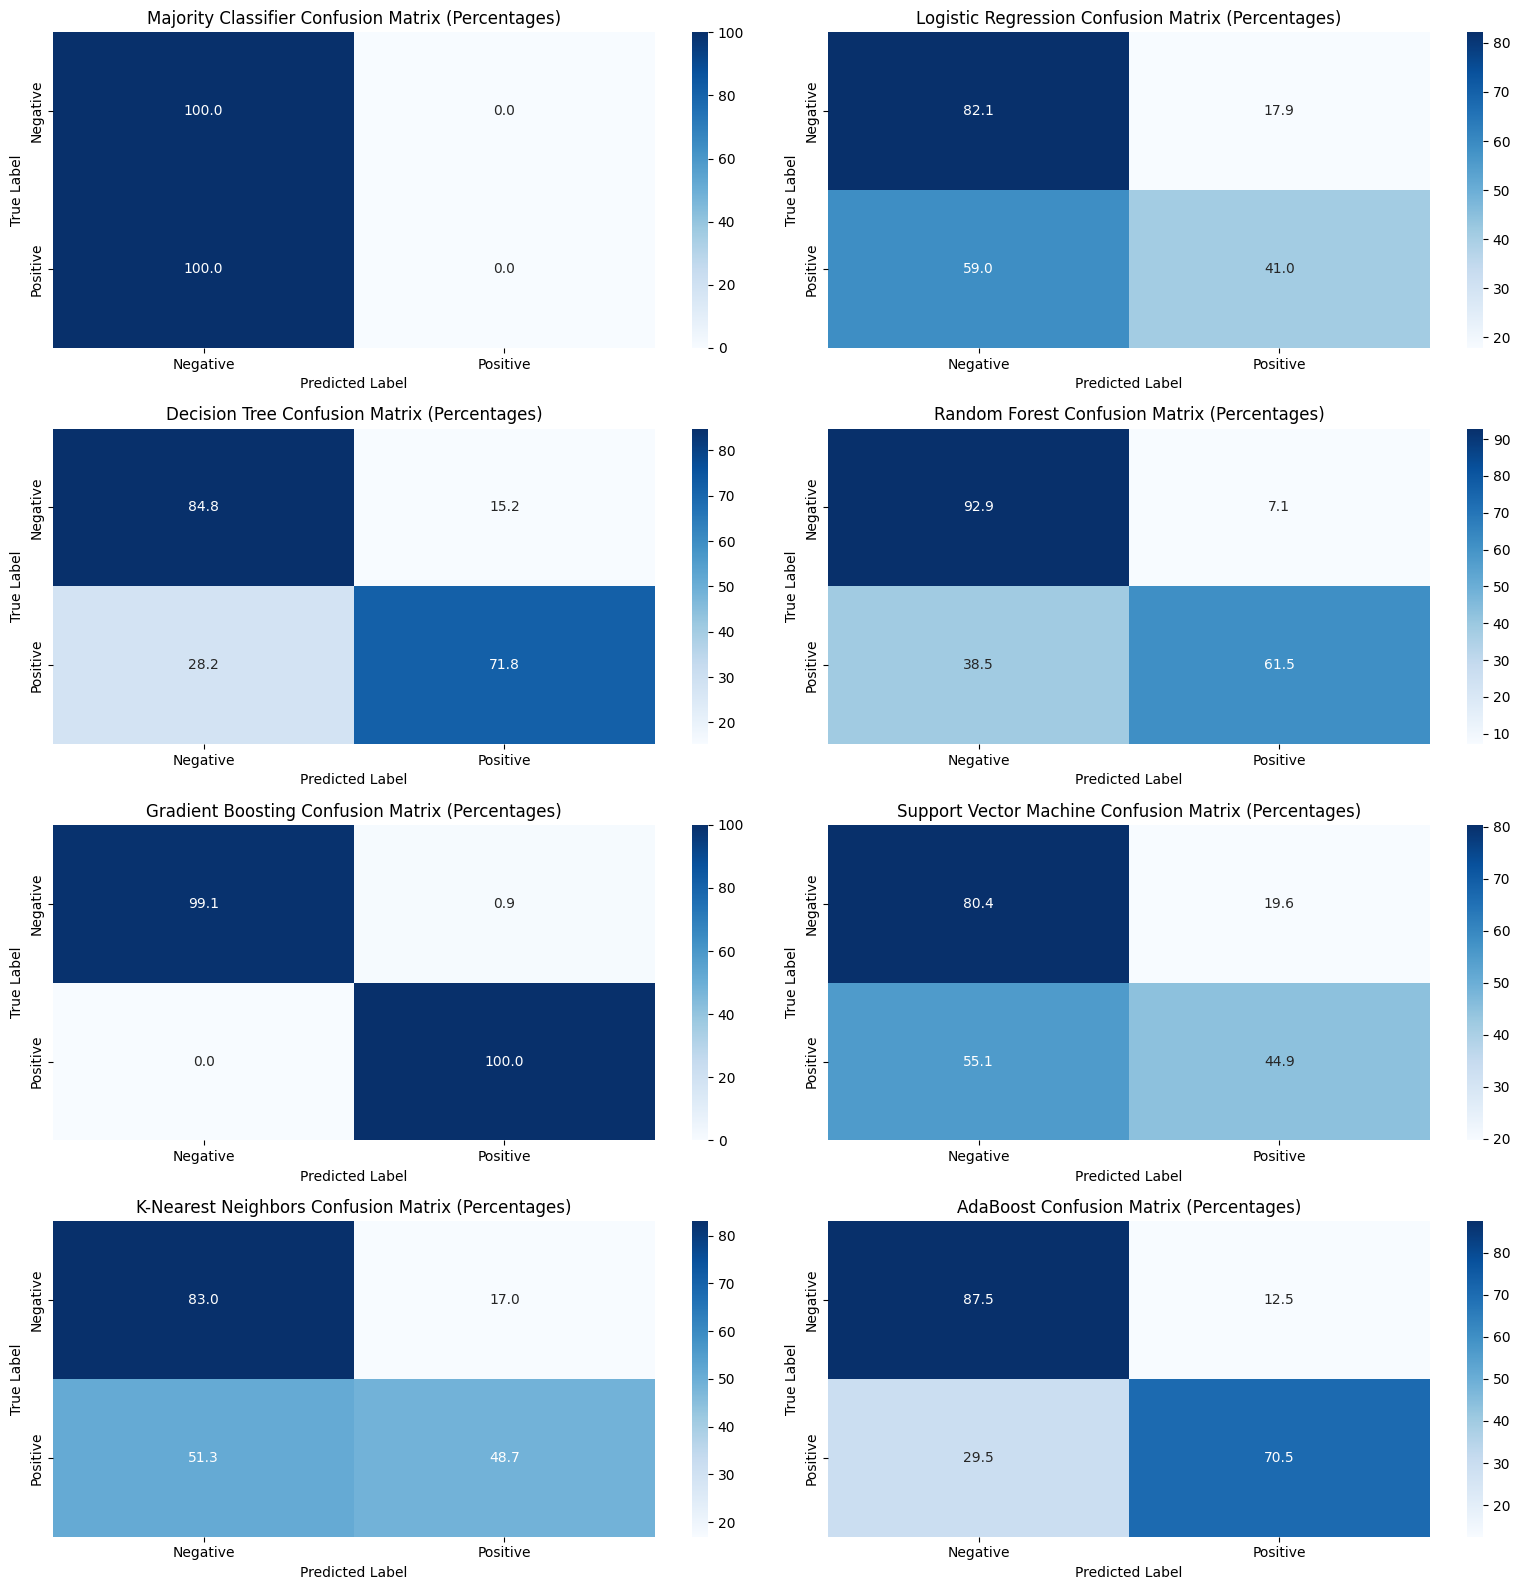

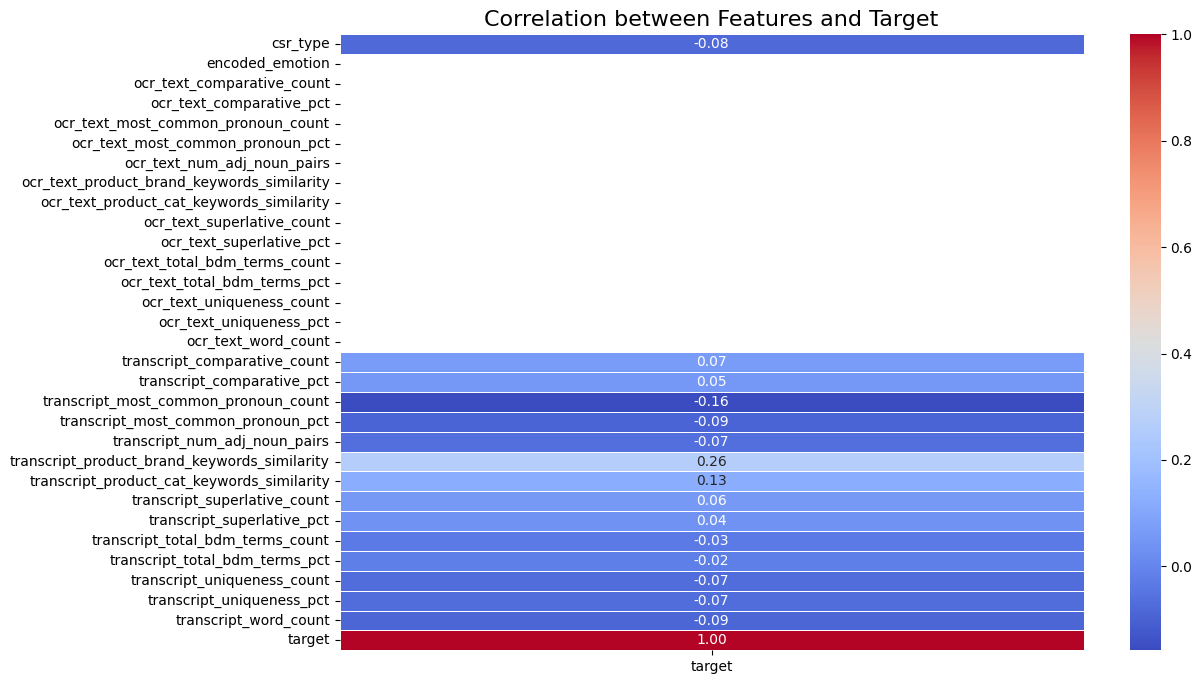

/tmp/ipykernel_26839/3400220485.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_data['majority_vote'] = predicted_data[['Logistic Regression_result', 'Random Forest_result', 'Support Vector Machine_result']].mode(axis=1)[0]


,commercial_number,BDM,Logistic Regression_result,Random Forest_result,Support Vector Machine_result,majority_vote
0,AD0252,0.0,TN,TN,TN,TN
1,AD0257,0.0,TN,TN,TN,TN
2,AD0258,0.0,FP,FP,FP,FP
3,AD0259,0.0,TN,TN,TN,TN
4,AD0260,0.0,TN,TN,TN,TN
5,AD0275,0.0,TN,TN,TN,TN
6,AD0276,1.0,FN,TP,FN,FN
7,AD0277,0.0,TN,TN,TN,TN
8,AD0291,0.0,FP,FP,FP,FP
9,AD0292,0.0,FP,TN,FP,FP



Decision Tree Analysis:


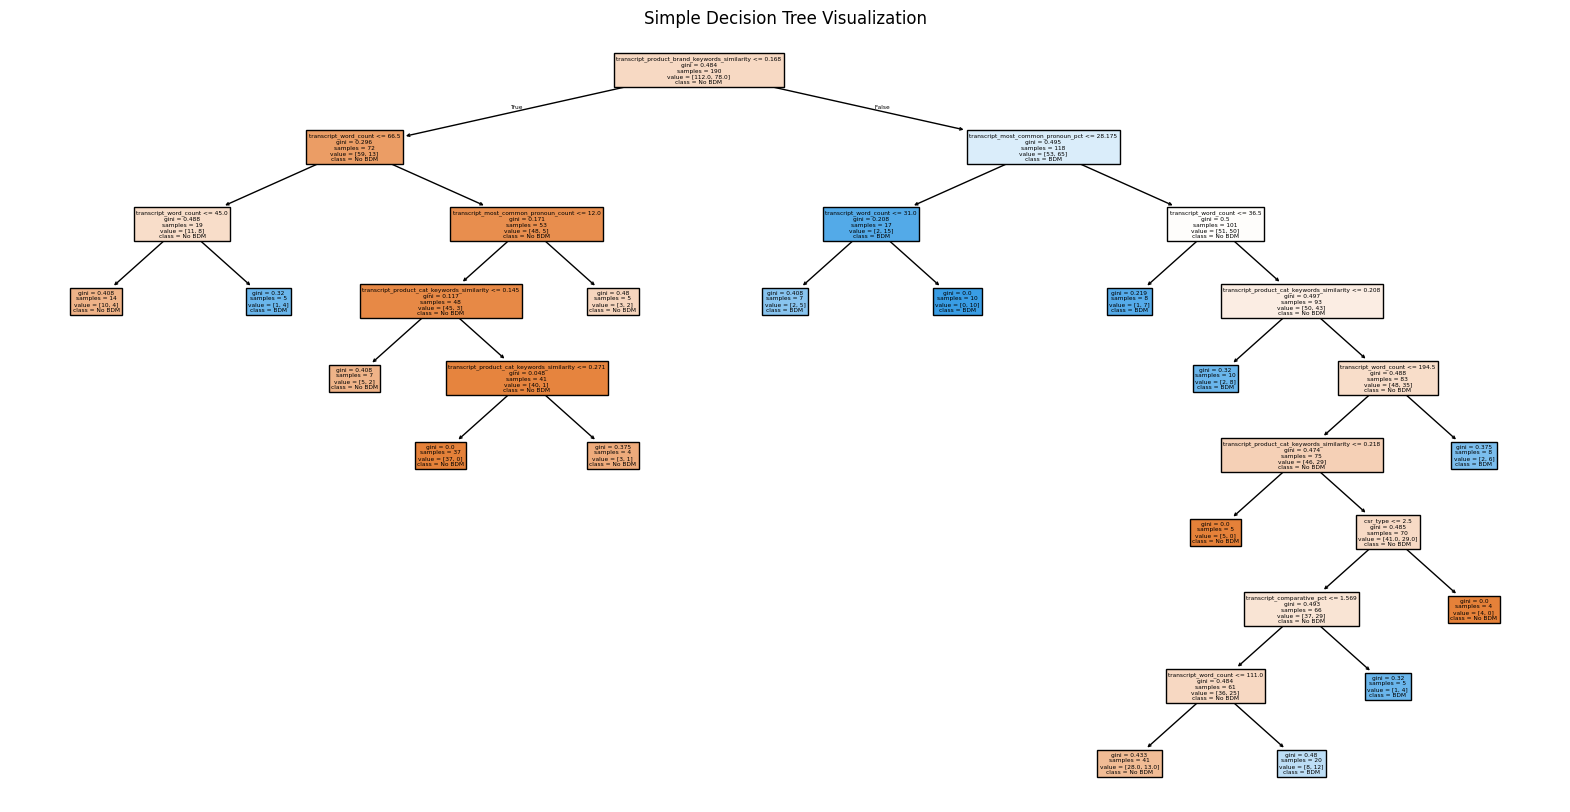


Feature Importance Ranking:
1. transcript_product_brand_keywords_similarity: 0.322
2. transcript_word_count: 0.319
3. transcript_product_cat_keywords_similarity: 0.142
4. transcript_most_common_pronoun_pct: 0.115
5. csr_type: 0.038
6. transcript_comparative_pct: 0.037
7. transcript_most_common_pronoun_count: 0.027
8. transcript_superlative_pct: 0.000
9. transcript_total_bdm_terms_pct: 0.000
10. transcript_total_bdm_terms_count: 0.000
11. transcript_uniqueness_pct: 0.000
12. transcript_superlative_count: 0.000
13. transcript_num_adj_noun_pairs: 0.000
14. transcript_uniqueness_count: 0.000
15. transcript_comparative_count: 0.000
16. ocr_text_word_count: 0.000
17. ocr_text_uniqueness_count: 0.000
18. ocr_text_uniqueness_pct: 0.000
19. ocr_text_total_bdm_terms_count: 0.000
20. ocr_text_superlative_pct: 0.000
21. ocr_text_superlative_count: 0.000
22. ocr_text_total_bdm_terms_pct: 0.000
23. ocr_text_product_cat_keywords_similarity: 0.000
24. ocr_text_product_brand_keywords_similarity: 0.000

In [42]:
results_df, predictions = m.evaluate_models(data, target, trained_models)
original_data = ad_df.copy()
display(original_data.head(10))
original_data = pd.concat([commercial_numbers, original_data, predictions], axis=1)
m.display_model_results(data, target, trained_models, results_df)
predicted_data = original_data[['commercial_number', 'BDM', 'Logistic Regression_result', 'Random Forest_result', 'Support Vector Machine_result']]
predicted_data['majority_vote'] = predicted_data[['Logistic Regression_result', 'Random Forest_result', 'Support Vector Machine_result']].mode(axis=1)[0]
display(predicted_data.head(10))
m.analyze_decision_tree(data, target, tuned_models)